# Attractor stability visualization

## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib
import re
import seaborn as sns

In [3]:
sns.set()

## Util

In [66]:
def read(path):
    df = pd.read_excel(path+"Final_states.xlsx", index_col=0)
    df = df.transpose()
    return df.loc[df.index.isin([a for a in df.index if 'Unnamed' not in a])]

In [5]:
def calculate_final_states_and_attractors_intercellular(df):
    states = df.index.to_numpy()
    initial_states = []
    attractors = [], []
    final_states = []
    for i in states:
        state = i.split('_')
        
        initial_states.append(state[0])
        
        res = re.findall('((EM|I)[0-9]+|[E, M][0-9]*)', state[-1])
        a1, a2 = res[0][0], res[1][0]
        attractors[0].append(a1)
        attractors[1].append(a2)
        
        attr = re.findall("[A-Z]+", state[-1])
        if len(attr) == 1:
            attr = [attr[0][0], attr[0][1]]
        final_states.append(' / '.join(attr))
        
    df.insert(0, 'initial_state', initial_states)
    df.insert(0, 'final_state', final_states)
    df.insert(0, 'attractor1', attractors[0])
    df.insert(0, 'attractor2', attractors[1])
    
    def get_real_attractor(cell_num):
        def get_attr(x):
            if int(x['dist_from_E_cell_' + cell_num]) <= 3: 
                return 'E' 
            if int(x['dist_from_M_cell_' + cell_num]) <= 3: 
                return 'M'
            return x['attractor' + cell_num]
        return get_attr
    
    for i, x in df.iterrows():
        a1, a2 = get_real_attractor('1')(x), get_real_attractor('2')(x)
        df.at[i,'attractor1'] = a1
        df.at[i,'attractor2'] = a2
        df.at[i,'attractors'] = ' / '.join(sorted([a1, a2]))

    return df

In [32]:
def calculate_final_states_and_attractors_single(df):
    states = df.index.to_numpy()
    initial_states = []
    attractors = []
    final_states = []
    for i in states:
        state = i.split('_')
        
        initial_states.append(state[0])
        
        res = re.findall('((EM|I)[0-9]+|[E, M][0-9]*)', state[-1])
        a1 = res[0][0]
        attractors.append(a1)
        
        attr = re.findall("[A-Z]+", state[-1])
        final_states.append(attr[0])
        
    df.insert(0, 'initial_state', initial_states)
    df.insert(0, 'final_state', final_states)
    df.insert(0, 'attractors', attractors)
    
    def get_attr(x):
        if int(x['dist_from_E']) <= 3: 
            return 'E' 
        if int(x['dist_from_M']) <= 3: 
            return 'M'
        return x['attractors']
    
    for i, x in df.iterrows():
        a1 = get_attr(x)
        df.at[i,'attractors'] = a1

    return df

In [72]:
def plot_distribution(df, title, field_name='final_state', steps=500):
    df2 = pd.DataFrame(df.groupby(['initial_state', field_name])['count'].sum())
    if field_name == 'attractors':
        df2 = df2.query(f'count > {steps*0.05}')
        
    df3 = df2.reset_index()

    init = df3['initial_state'].unique()
    final = df3[field_name].unique()

    matrix = [{fin: df2.loc[init_s, fin][0] if fin in df2.loc[init_s].index else 0 for fin in final} for init_s in init]
    
    L = len(matrix[0])
    sns.set_palette(sns.color_palette('Spectral', L))
    
    df4 = pd.DataFrame(matrix, index=init)
    ax = df4.plot.bar(stacked=True, linewidth=0)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

    cols = df4.columns
    summ = [sum(a) for _, a in df4.iterrows()]
    sep = ' '
    if len(df4.index) > 2:
        sep = '\n'
    for i, row in df4.reset_index().iloc[:, 1:].iterrows():
        current_sum = 0
        for j, val in enumerate(row):
            if val/summ[i] > 0.03:
                plt.text(i, current_sum + val / 2, f"{(val/summ[i]*100):.1f}%{sep}({cols[j]})", ha='center', va='center', fontweight='bold')
            current_sum += val
    plt.gcf().set_size_inches(7, 5)
    plt.title(title, fontsize=20)
    plt.tight_layout()

# Init

## Kiértékelés

In [286]:
paths_and_names_intercellular = [("/Users/ftedo/Desktop/Szakdolgozat/simulations/intercellular/no-perturbation/asynchronous/original/", "inter_nopert_wasync_origin"),
                  ("/Users/ftedo/Desktop/Szakdolgozat/simulations/intercellular/no-perturbation/asynchronous/with-pathways/", "inter_nopert_wasync_pathw"),
                    ("/Users/ftedo/Desktop/Szakdolgozat/simulations/intercellular/perturbation/asynchronous/original/", "inter_pert_wasync_origin"),
                   ("/Users/ftedo/Desktop/Szakdolgozat/simulations/intercellular/perturbation/asynchronous/with-pathways/", "inter_pert_wasync_pathw")]

paths_and_names_single = [("/Users/ftedo/Desktop/Szakdolgozat/simulations/single-cell/no-perturbation/asynchronous/original/", "single_nopert_wasync_origin"),
                   ("/Users/ftedo/Desktop/Szakdolgozat/simulations/single-cell/no-perturbation/asynchronous/with-connections/", "single_nopert_wasync_pathw"),
                   ("/Users/ftedo/Desktop/Szakdolgozat/simulations/single-cell/perturbation/asynchronous/with-pathways/", "single_pert_wasync_pathw"),
                   ("/Users/ftedo/Desktop/Szakdolgozat/simulations/single-cell/perturbation/asynchronous/original/", "single_pert_wasync_origin")]

inter_nopert_wasync_origin
inter_nopert_wasync_pathw
inter_pert_wasync_origin
inter_pert_wasync_pathw


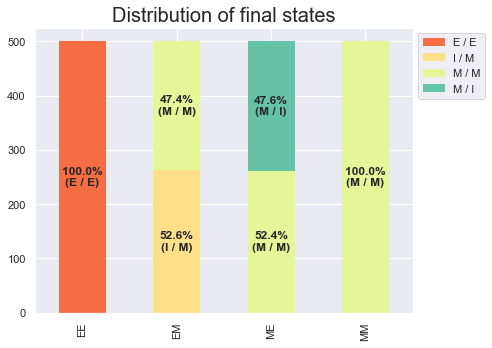

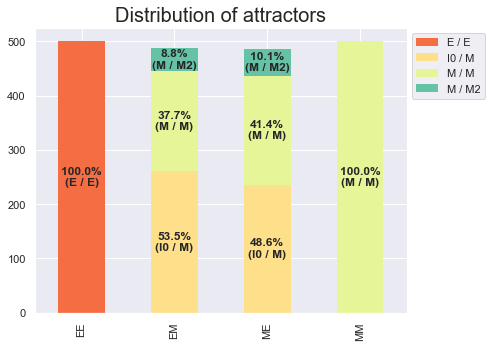

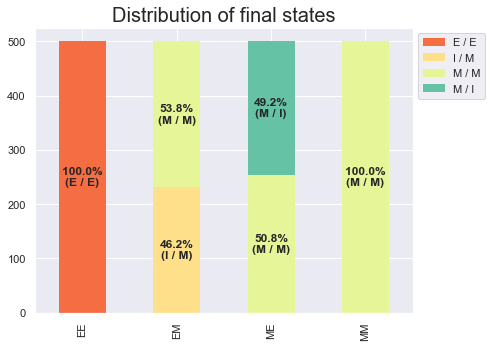

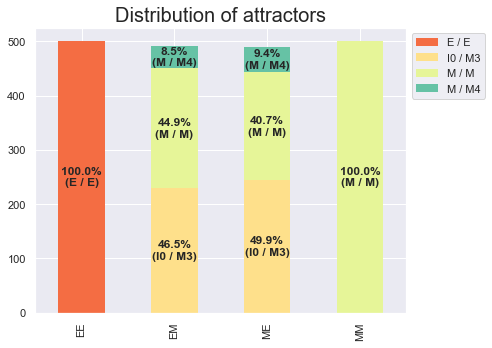

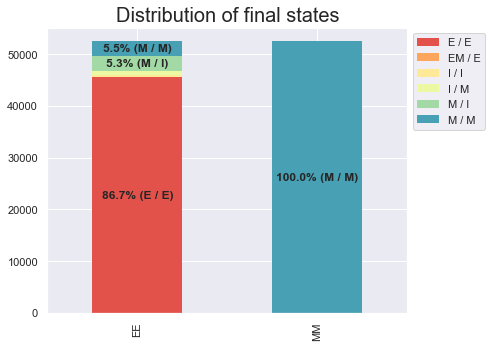

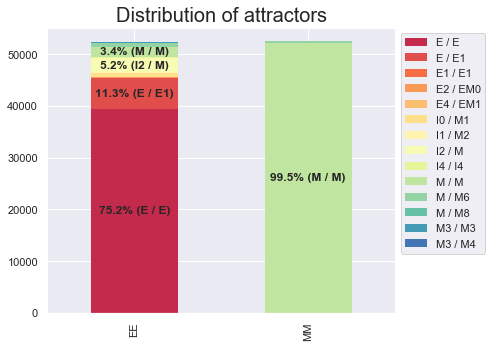

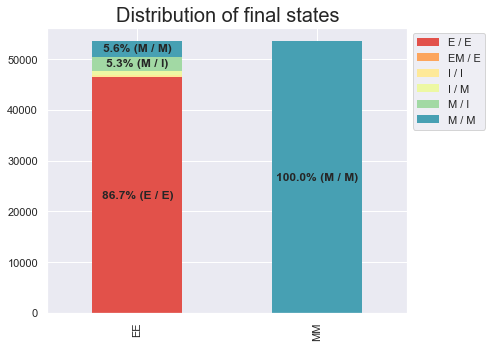

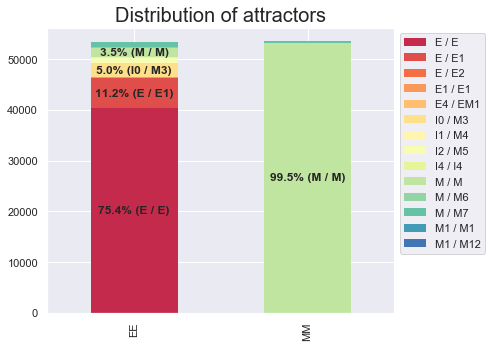

In [288]:
for path, name in paths_and_names_intercellular:
    df = read(path=path)
    df = calculate_final_states_and_attractors_intercellular(df)
    
    plot_distribution(df, title = 'Distribution of final states')
    plt.savefig(path+name+'_final')
    
    plot_distribution(df, title = 'Distribution of attractors', field_name = 'attractors')
    plt.savefig(path+name+'_attractors')
    print(name)

In [ ]:
for path, name in paths_and_names_single:
    df = read(path=path)
    df = calculate_final_states_and_attractors_single(df)
    
    plot_distribution(df, title = 'Distribution of final states')
    plt.savefig(path+name+'_final')
    
    plot_distribution(df, title = 'Distribution of attractors', field_name = 'attractors')
    plt.savefig(path+name+'_attractors')
    print(name)

## KI/KO

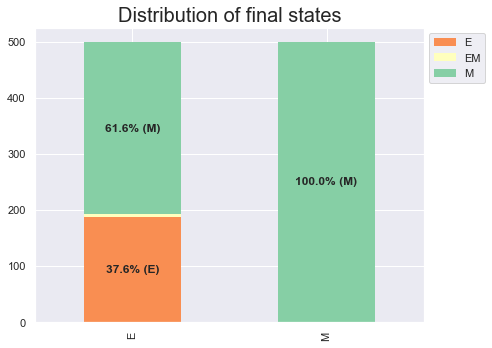

In [73]:
df = read("/Users/ftedo/Desktop/Szakdolgozat/simulations/KI:KO/IGF/IGF1R/single/")
df = calculate_final_states_and_attractors_single(df)
plot_distribution(df, title = 'Distribution of final states')
plt.savefig("/Users/ftedo/Desktop/Szakdolgozat/simulations/KI:KO/IGF/IGF1R/single/IGF1R_single")

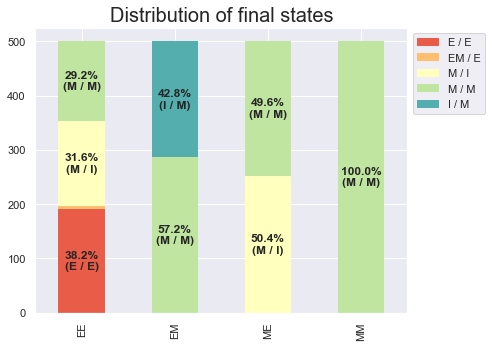

In [74]:
df = read("/Users/ftedo/Desktop/Szakdolgozat/simulations/KI:KO/IGF/IGF1R/intercellular/")
df = calculate_final_states_and_attractors_intercellular(df)
plot_distribution(df, title = 'Distribution of final states')
plt.savefig("/Users/ftedo/Desktop/Szakdolgozat/simulations/KI:KO/IGF/IGF1R/intercellular/IGF1R_intercellular")